In [1]:
#Potato Disease Classification Using CNN 

<span style='font-family:Lato'><span style='font-size:110%'>
    Agricultural Industry is thriving making use of the top-notch technology in their day-to-day business which help them produce better crop , take better desicions. <br>
    Our today's aim is to analyse the two main diseases in Potato Farming namely : Early Blight and <br>
    For the same we'll be using the <a href = 'https://www.kaggle.com/datasets/arjuntejaswi/plant-village'>Kaggle Dataset</a>.<br>
    </span>

In [2]:
#--Importing the required libraries
import tensorflow as tf
from IPython.display import HTML 
from tensorflow.keras import models,layers
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style = 'whitegrid', context = 'paper', font_scale = 0.9, font = 'Georgia')

In [3]:
#--Loading the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Potato',
    shuffle = True,
    image_size = (256,256),
    batch_size = 32
)

Found 2152 files belonging to 3 classes.


In [4]:
#--Getting the class names
class_names = dataset.class_names
type(class_names)

list

In [5]:
#--Confirming the length of the data 
print(f"The length of the data : {len(dataset)} \n The actual length of the data : {len(dataset)*32}")

The length of the data : 68 
 The actual length of the data : 2176


In [6]:
#--Getting the general idea of the dataset
for image_batch, label_batch in dataset.take(1): #--this dataset.take(1) only takes one batch 
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 2 0 1 0 0 0 0]


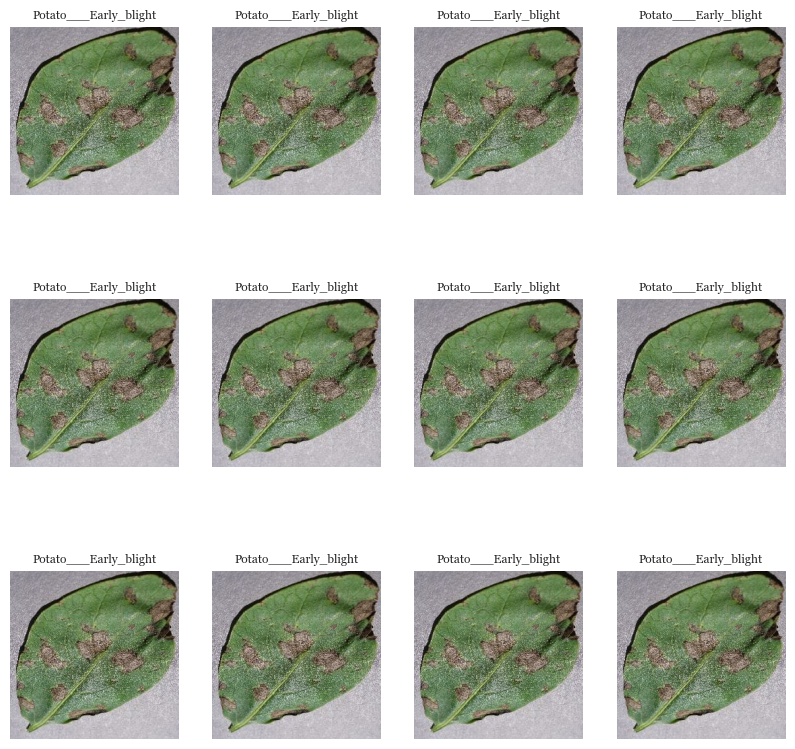

In [7]:
#--Plotting the various figure
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1): #--each time it will print new one because it is shuffling
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype('uint8'))
        plt.title(class_names[label_batch[0]])
        plt.axis('off')

In [8]:
'''
train_size = 68*0.8
train_size
test_size = 68*0.2
test_size 
val_size = 68*0.1
print(f"Training size is : {train_size} \n Testing size is : {test_size} \n Validation size is :{ val_size }")


train_data = dataset.take(54)

test_data = dataset.skip(54)

val_data = test_data.take(6)
test_data = test_data.skip(6)
'''

'\ntrain_size = 68*0.8\ntrain_size\ntest_size = 68*0.2\ntest_size \nval_size = 68*0.1\nprint(f"Training size is : {train_size} \n Testing size is : {test_size} \n Validation size is :{ val_size }")\n\n\ntrain_data = dataset.take(54)\n\ntest_data = dataset.skip(54)\n\nval_data = test_data.take(6)\ntest_data = test_data.skip(6)\n'

In [9]:
#--UDF for getting the different parts from data
def get_partition_df(df, train_size = 0.8 , test_size = 0.1, valid_size = 0.1, shuffle = True, shuffle_size = 10000):
    if shuffle:
        df = df.shuffle(shuffle_size, seed = 12)
    val_1 = round(len(df)*train_size)
    val_2 = round(len(df)*test_size)
    train_data = df.take(val_1)
    test_data = df.skip(val_1)
    valid_data = test_data.take(val_2)
    test_data = test_data.skip(val_2)
    return train_data,test_data,valid_data

In [10]:
train_data,test_data,valid_data = get_partition_df(dataset)

In [11]:
#--Cache and prefetch 
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
valid_data = valid_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [12]:
#--Resizing and Rescaling  
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/256)
    
])

In [13]:
#--Image Auguentation --> To make a robust data
data_augumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)    
])

In [14]:
#--Building a simple CNN model
n_classes = 3
input_shape = (32, 256,256, 3)
model = models.Sequential([
    resize_and_rescale,
    data_augumentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes , activation = 'softmax')
])

model.build(input_shape = input_shape)

In [15]:
#--Model Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [16]:
#--Compiling the model
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [17]:
#--Fitting the model
history = model.fit(
    train_data,
    epochs = 5, #--I could've used more epochs but that was taking a lot of time
    batch_size = 32,
    verbose = 1,
    validation_data = valid_data
)

Epoch 1/5
54/54 [==============================] - 192s 3s/step - loss: 0.9025 - accuracy: 0.4936 - val_loss: 0.8989 - val_accuracy: 0.4330
Epoch 2/5
54/54 [==============================] - 168s 3s/step - loss: 0.8586 - accuracy: 0.5596 - val_loss: 0.6799 - val_accuracy: 0.6607
Epoch 3/5
54/54 [==============================] - 168s 3s/step - loss: 0.5745 - accuracy: 0.7645 - val_loss: 0.5740 - val_accuracy: 0.7812
Epoch 4/5
54/54 [==============================] - 165s 3s/step - loss: 0.4582 - accuracy: 0.8142 - val_loss: 0.3338 - val_accuracy: 0.8839
Epoch 5/5
54/54 [==============================] - 164s 3s/step - loss: 0.3704 - accuracy: 0.8490 - val_loss: 0.2920 - val_accuracy: 0.8839


In [18]:
#--Getting the scores
scores = model.evaluate(test_data)
print(f"Final Loss : {scores[0]}  \n Final Accuracy : {scores[1]}")

7/7 [==============================] - 9s 688ms/step - loss: 0.3608 - accuracy: 0.8393
Final Loss : 0.36084434390068054  
 Final Accuracy : 0.8392857313156128


In [19]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

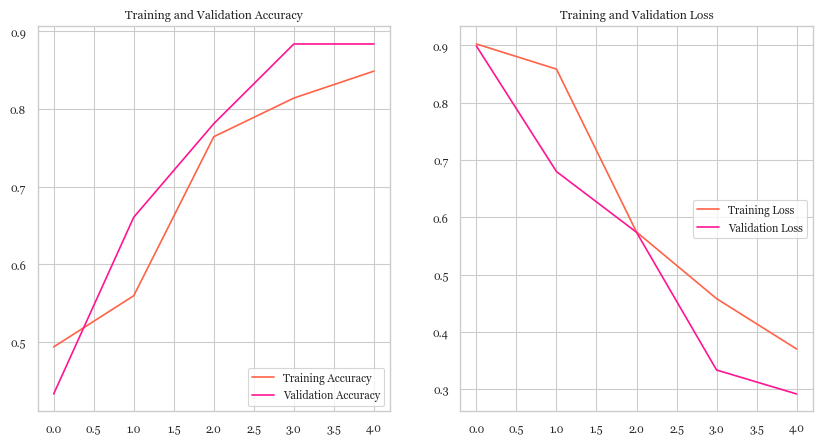

In [24]:
#--Plotting the accuracy and loss
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(range(5),accuracy, label = 'Training Accuracy', color = 'tomato')
plt.plot(range(5), val_accuracy, label = 'Validation Accuracy', color = 'deeppink')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(5),loss, label = 'Training Loss', color = 'tomato')
plt.plot(range(5), val_loss, label = 'Validation Loss', color = 'deeppink')
plt.legend(loc = 'right')
plt.title('Training and Validation Loss')

plt.show()

In [21]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 47ms/step


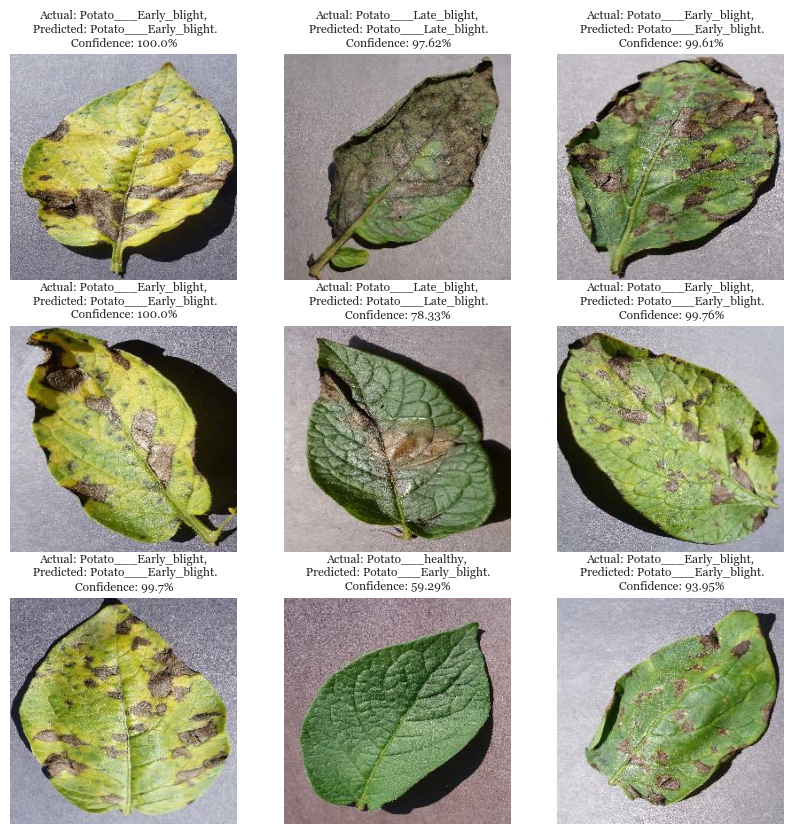

In [22]:
#--Visualising the result
plt.figure(figsize=(10,10))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

<span style='font-family:Lato'><span style='font-size:110%'>
We can see how well our model performs using only 5 epochs.
</span>